In [2]:
from scipy.stats import entropy
from scipy.ndimage import filters
import numpy as np, pandas  as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, average_precision_score, log_loss as NLLL
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.dpi"] = 85

## Data Preprocessing

In [4]:
seed = 19
np.random.seed(seed)
# load the data
with open("hrms-data", "rb") as f:
    data = pickle.load(f)
    
# get the good and bad dataframes
bad = data.get("bad").copy()
good = data.get("good").copy()

# add the quality column to the dataframes
bad["quality"] = 0
good["quality"] = 1

# put both into a big dataframe
data = pd.concat([good, bad])

MASS = "MS2.mz"
INTENSITY = "MS2.intensity"
IO = "IO"
CE = "CE"
NAME = "name"
QUALITY = "quality"
PRECURSOR = "precursor"

# the UID is IO_CE_NAME_QUALITY
def assign_UID(row):
    return str(row[IO])+"_"+str(row[CE])+"_"+str(row[NAME])+"_"+str(row[QUALITY])

UID = "UID"
data[UID] = data.apply(assign_UID, axis=1)

In [5]:
joint = set([_ for _ in bad.name.unique() if _ in good.name.unique()])

In [6]:
# take a random sample with good and bad
mol_name = np.random.choice(list(joint))
print(mol_name)
mol_name = 'Sitagliptine'

Denatonium


In [7]:
plt.style.use('seaborn')

Sitagliptine : IO: +      PREC: 408.13
GOOD: CE: 50
BAD:  CE: 10


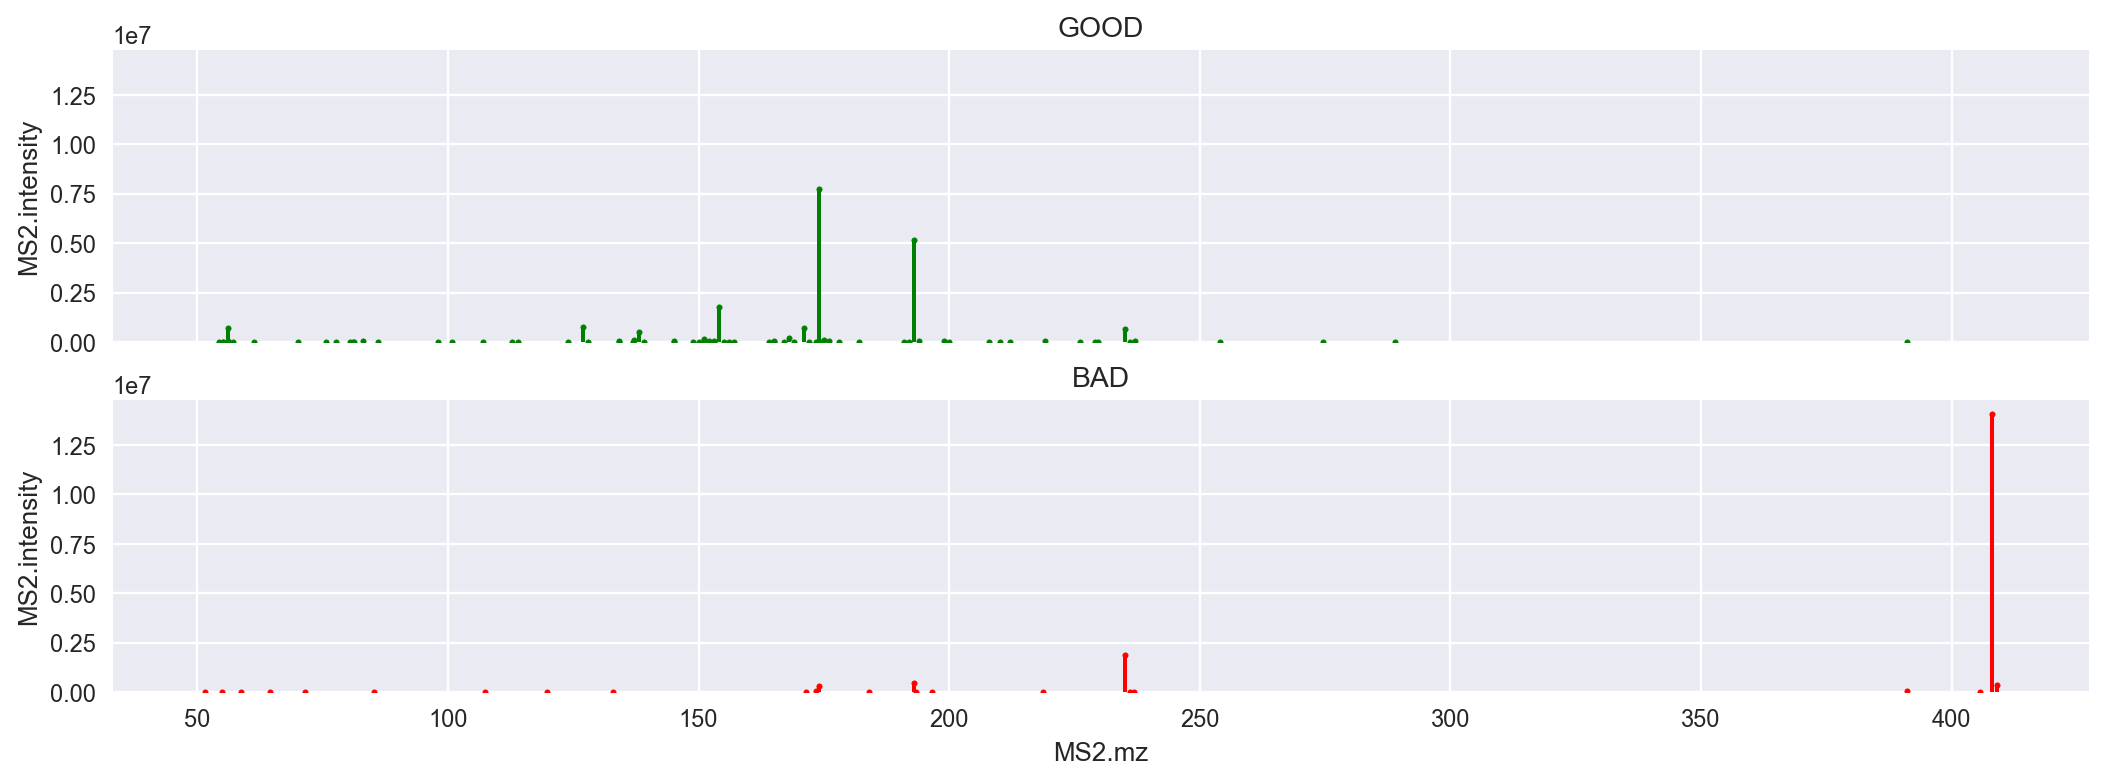

In [8]:
# visualize a good and a bad spectra of the same molecule
fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(15,5), sharex=True, sharey=True)  
axes[0].set_title("GOOD"); axes[1].set_title("BAD")
good_molecules = data[(data.name == mol_name) & (data.quality==1)]
bad_molecules = data[(data.name == mol_name) & (data.quality==0)]
good_mol = data[data.UID == np.random.choice(good_molecules.UID.unique())]
matplotlib.axes.Axes.bar(x=good_mol[MASS], height=good_mol[INTENSITY], color='g', ax=axes[0])
good_mol.plot(x=MASS, y=INTENSITY,ax=axes[0], kind="scatter", c='g', marker=".")
# axes[0].set_xlim([40, 400]); axes[0].set_ylim([-100000, 3200000])
bad_mol = data[data.UID == np.random.choice(bad_molecules.UID.unique())]
matplotlib.axes.Axes.bar(x=bad_mol[MASS], height=bad_mol[INTENSITY], color='r', ax=axes[1])
bad_mol.plot(x="MS2.mz", y="MS2.intensity",ax=axes[1], kind="scatter", c='r', marker=".")
# axes[1].set_xlim([40, 400]); axes[1].set_ylim([-100000, 3200000])
print(mol_name,': IO:', good_mol.IO.unique()[0], '     PREC:', np.round(good_mol['precursor'].unique()[0], 2))
print('GOOD: CE:', good_mol.CE.unique()[0])
print('BAD:  CE:', bad_mol.CE.unique()[0])

In [9]:
# scale the mass by dividing with the precursor
data[MASS] = data[MASS]/data[PRECURSOR]

# scale intensity by dividing with max
def scale_intensity(data):
    data_norm = []
    for uid in data.UID.unique():
        sample_df = data[data.UID==uid].copy()
        sample_df[INTENSITY] = sample_df[INTENSITY] / sample_df[INTENSITY].max()
        data_norm.append(sample_df)
    return pd.concat(data_norm).reset_index(drop=True)

data = scale_intensity(data)

# remove noise, choose a threshold
threshold = .05
max_intensity = {uid : data[data[UID] == uid ][INTENSITY].max() for uid in data.UID.unique()}
mask = data.apply(lambda row : True if (row[INTENSITY] / max_intensity[row[UID]]) > threshold else False, axis=1)
data_copy = data.copy()
data = data_copy[mask].reset_index(drop=True)

with open("test_uids", "rb") as f:
    test_uids = pickle.load(f)

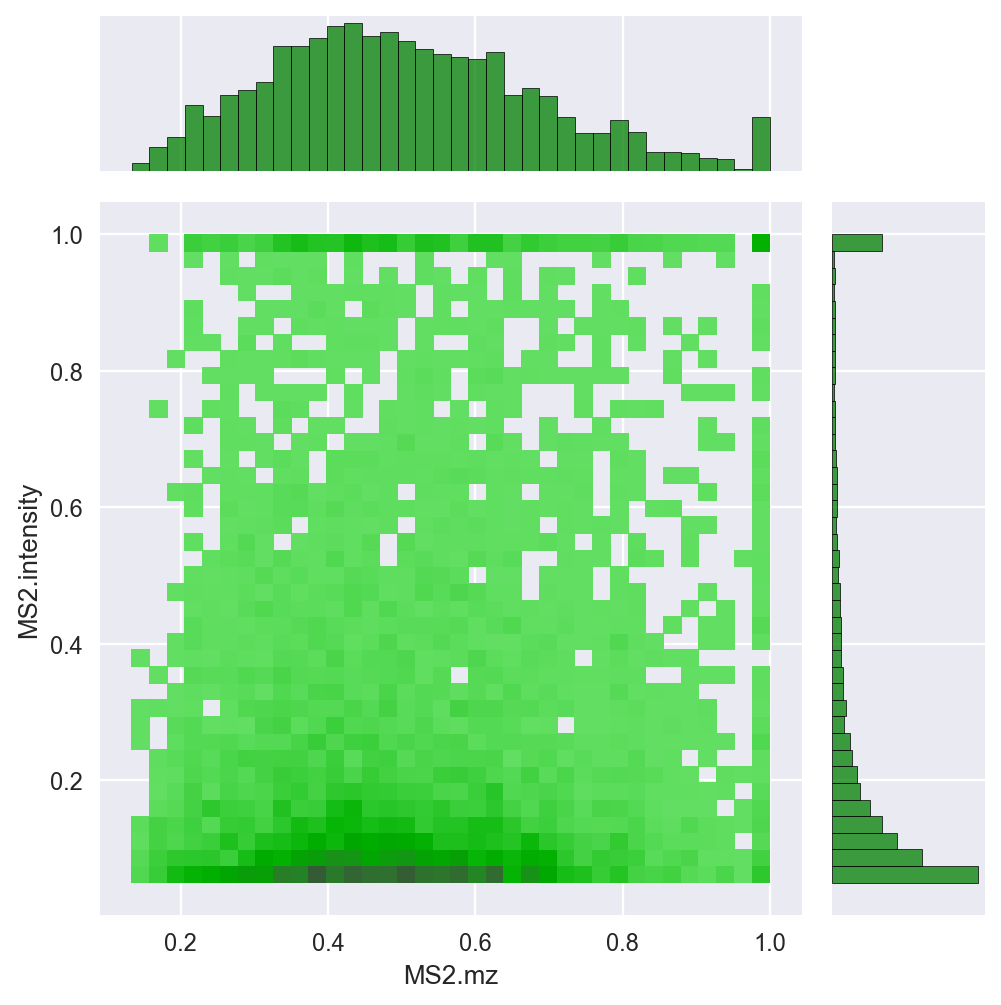

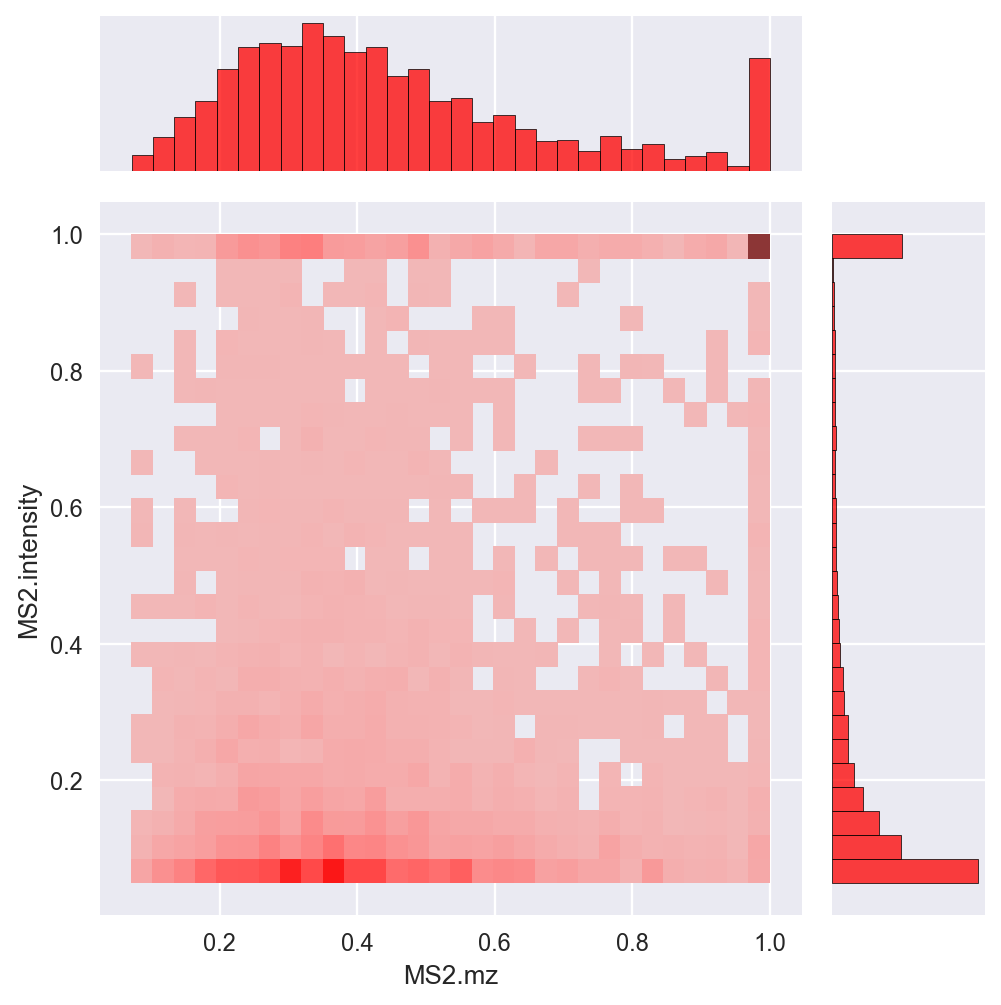

In [10]:
plt.style.use('seaborn')
sns.jointplot(data = data[(data[MASS] <= 1) & (data.quality == 1)], y = INTENSITY, x = MASS, kind="hist", ratio=4, color="green")
sns.jointplot(data = data[(data[MASS] <= 1) & (data.quality == 0)], y = INTENSITY, x = MASS, kind="hist", ratio=4, color="red")

## Feature extraction

In [11]:
def extract_baseline(data):
    D = []
    for uid in data.UID.unique():
        sample = data[data.UID == uid].copy()
        quality = 1 if sample.quality.sum() else 0
        feats = {'quality': quality, 'UID': uid}
        x = sample[MASS].to_numpy()
        y = sample[INTENSITY].to_numpy()
        no_peaks = len(sample)
        feats.update({'no_peaks': no_peaks})
        D += [feats]
            
    return pd.DataFrame(D)


def extract_grid_features(data, bin_dim=(19, 1), smooth_bins=False, smoothing_factor=.5, base_feats=True):
    D = []
    for uid in data.UID.unique():
        sample = data[data.UID == uid].copy()
        quality = 1 if sample.quality.sum() else 0
        feats = {'quality': quality, 'UID': uid}
        x = sample[MASS].to_numpy()
        y = sample[INTENSITY].to_numpy()
        if base_feats:
            ce = int(sample.CE.unique()[0])
            precursor = float(sample.precursor.unique()[0])
            feats.update({ 'ce': ce, 'prec': precursor})
        H, xedges, yedges = np.histogram2d(x, y, bins=bin_dim)

        H = filters.gaussian_filter(H, smoothing_factor) if smooth_bins else H
        H = H.ravel()
        feats.update({'C_%s' %c : H[c] for c in range(len(H))})
        
        D += [feats]
    return pd.DataFrame(D)

def extract_uneven_grid_features(data, bin_dim=14, smooth_bins=False, smoothing_factor=.5, base_feats=True):
    D = []
    for uid in data.UID.unique():
        sample = data[data.UID == uid].copy()
        quality = 1 if sample.quality.sum() else 0
        feats = {'quality': quality, 'UID': uid}
        x = sample[MASS].to_numpy()
        y = sample[INTENSITY].to_numpy()
        if base_feats:
            ce = int(sample.CE.unique()[0])
            precursor = float(sample.precursor.unique()[0])
            feats.update({ 'ce': ce, 'prec': precursor})
        u_bins = []
        u = y.max()
        u_bins.append(u)
        for i in range(bin_dim-1):
            u = u/2
            u_bins.append(u)
        u_bins.append(0)
        u_bins.reverse()
        count = np.zeros(len(u_bins)-1)
        for i in range(len(y)):
            j=0
            for l,r in zip(u_bins[:-1], u_bins[1:]):
                if y[i] > l and y[i] <= r:
                    count[j]+=1
                j+=1
        feats.update({'UI_%s' %c : count[c] for c in range(len(count))})
        
        D += [feats]
    return pd.DataFrame(D)

def extract_lit(data, base_feats=True):
    D = []
    for uid in data.UID.unique():
        sample = data[data.UID == uid].copy()
        quality = 1 if sample.quality.sum() else 0
        feats = {'quality': quality, 'UID': uid}
        x = sample[MASS].to_numpy()
        y = sample[INTENSITY].to_numpy()
        if base_feats:
            ce = int(sample.CE.unique()[0])
            precursor = float(sample.precursor.unique()[0])
            feats.update({ 'ce': ce, 'prec': precursor})
        no_peaks = len(sample)
        ratio_higher_than_10 = len(y[y > 0.1])/len(y)
        ratio_higher_than_20 = len(y[y > 0.2])/len(y)
        entr_in = entropy(y)
        entr_mz = entropy(x)
        mean_intensity = np.mean(y)
        sd_intensity = np.std(y)
        total_intensity = np.sum(y)
        total_mz_times_intensity = np.sum(x*y)
        threshold = x.min() + ((x.max() - x.min())/5)
        intensity_balance = y[x < threshold].sum() - y[x >= threshold].sum()
        sd_mz_gaps = np.std([t - s for s, t in zip(x, x[1:])]) if len(x)>1 else 0
        count = np.zeros(len(np.arange(x[0], x[-1], 2)))
        for i in range(len(x)):
            j=0
            for l,r in zip(np.arange(x[0], x[-1], 2), np.arange(x[0]+2, x[-1]+2, 2)):
                if x[i] >= l and x[i] < r:
                    count[j]+=1
                j+=1
        mean_no_peaks_2da = np.mean(count) if len(x)>1 else 1
        # mean intensity 2Da
        feats.update({'no_peaks': no_peaks, 'ratio_higher_than_10': ratio_higher_than_10,
                      'ratio_higher_than_20': ratio_higher_than_20,
                     'mean_in': mean_intensity, 'sd_in': sd_intensity,
                     'total_in': total_intensity, 'dot_product': total_mz_times_intensity,
                     'in_balance': intensity_balance, 'sd_mz_gaps': sd_mz_gaps,
                     'mean_no_peaks_2da': mean_no_peaks_2da, 'entr_in': entr_in, 'entr_mz': entr_mz})
        D += [feats]
            
    return pd.DataFrame(D)

def extract_2dh(data, base_feats=True):
    D = []
    for uid in data.UID.unique():
        sample = data[data.UID == uid].copy()
        quality = 1 if sample.quality.sum() else 0
        feats = {'quality': quality, 'UID': uid}
        x = sample[MASS].to_numpy()
        y = sample[INTENSITY].to_numpy()
        if base_feats:
            ce = int(sample.CE.unique()[0])
            precursor = float(sample.precursor.unique()[0])
            feats.update({ 'ce': ce, 'prec': precursor})
        X = sample[[MASS, INTENSITY]].to_numpy()
        centroid = X.mean(0)
        dists = np.sqrt(((X - centroid)**2).sum(1))
        count = len(dists)
        minimum = dists.min()
        maximum = dists.max()
        mean = dists.mean()
        std = dists.std()
        q50 = np.quantile(dists, .50)
        q25 = np.quantile(dists, .25)
        q75 = np.quantile(dists, .75)
        feats.update({
            "count_dist": count,
            "min_dist" : minimum,
            "max_dist" : maximum,
            "mean_dist" : mean,
            "std_dist" : std,
            "q50_dist" : q50,
            "q25_dist" : q25,
            "q75_dist" : q75
        })
        D += [feats]
    return pd.DataFrame(D)

In [12]:
def validate(df, model):
    df_train = df[~df.UID.isin(test_uids)].copy().reset_index(drop=True)
    X = df_train[[col for col in df_train if col not in ['quality', 'UID']]].copy().to_numpy()
    y = df_train.quality.copy().to_numpy()
    kf = StratifiedKFold(10, shuffle=True, random_state=seed)
    metrics = []
    for train_index, val_index in tqdm(kf.split(X, y)):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model = model.fit(x_train, y_train)
        preds = model.predict(x_val)
        metrics += [[accuracy_score(y_val, preds),
                    precision_score(y_val, preds),
                    recall_score(y_val, preds),
                    average_precision_score(y_val, model.predict_proba(x_val)[:,1]),
                    roc_auc_score(y_val, model.predict_proba(x_val)[:,1]), 
                    NLLL(y_val, preds)]]
    results = pd.DataFrame(metrics, columns=['accuracy', 'precision', "recall", 'avg_precision', "roc_auc","log_loss"])
    
    return results

# Feature correlation: Spearman's rank

In [13]:
# sns.set_theme(style="ticks")

In [14]:
def show_corr(X_df):
    correlations = X_df.corr(method='spearman').to_numpy()
    plt.figure(figsize=(12,5))
    dissimilarity = 1 - abs(correlations)
    Z = linkage(squareform(dissimilarity), 'complete')
    dendrogram(Z, labels=X_df.columns, orientation='top', leaf_rotation=90)

In [15]:
df = pd.merge(extract_lit(data, base_feats=True), extract_2dh(data, base_feats=False), on=["UID","quality"])
# df = pd.merge(df, extract_grid_features(data, (2,11)), on=["UID","quality"])
df_train = df[~df.UID.isin(test_uids)].copy().reset_index(drop=True)
X_df = df_train[[col for col in df_train if col not in ['quality', 'UID']]].copy()

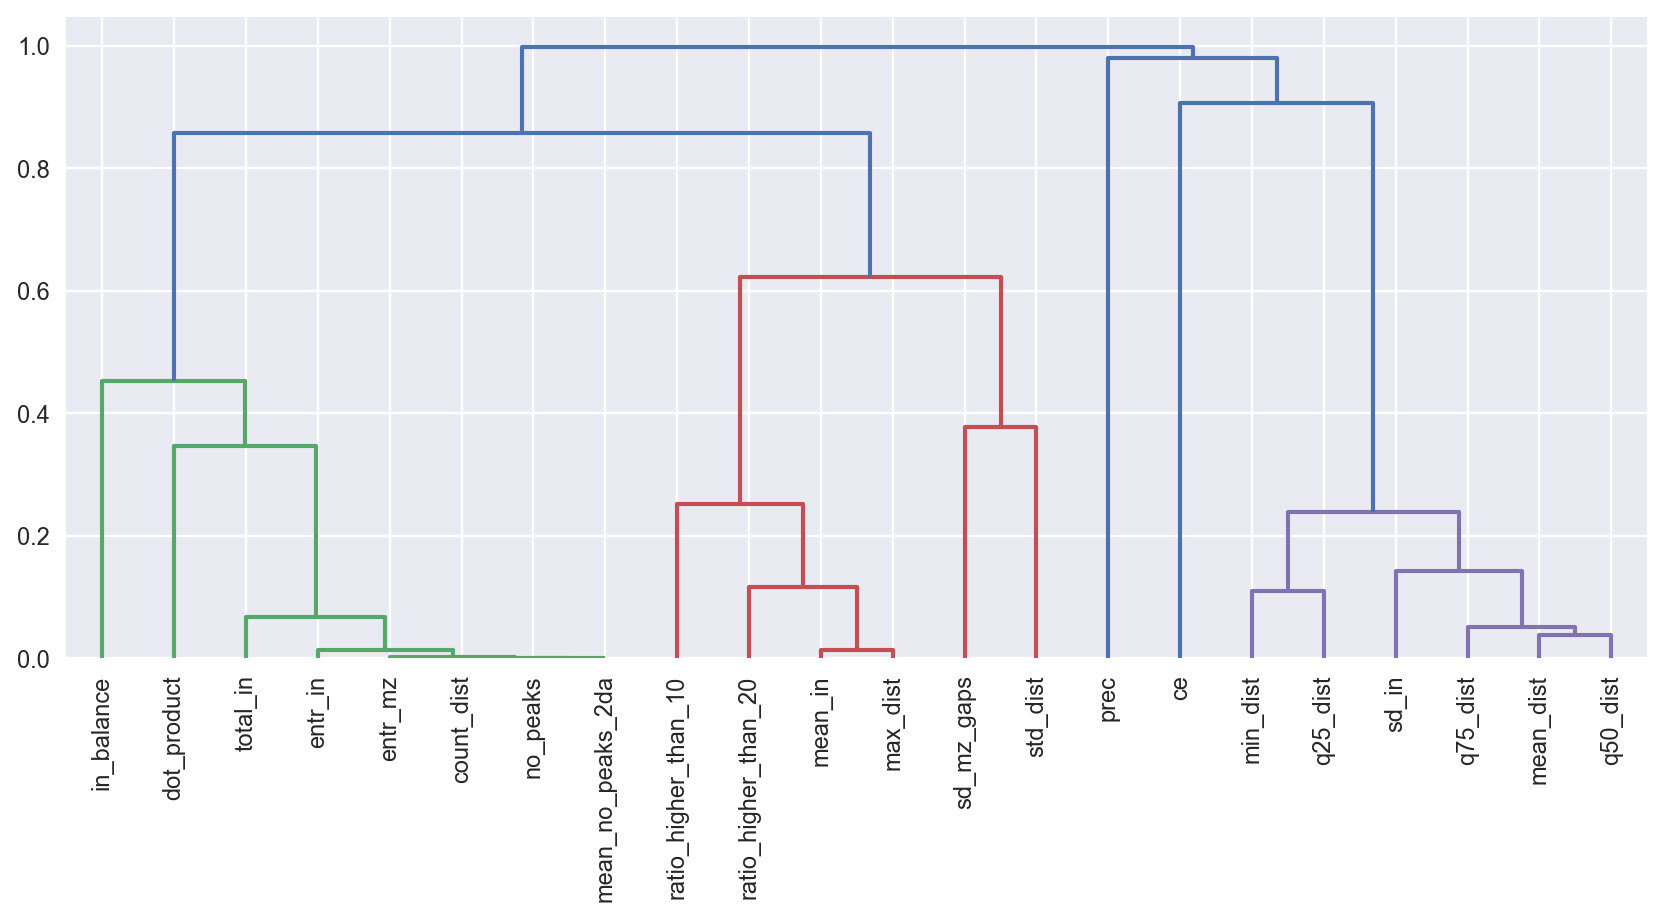

In [16]:
show_corr(X_df)

In [50]:
def uncorr(X_df, t, method="spearman"):
#     corr = X_df.corr(method=method)
#     no_corr = ~(corr.mask(np.tril(np.ones([len(corr)]*2, dtype=bool))).abs() > t).any()
#     return X_df[no_corr.loc[no_corr[no_corr.index] == True].index]
    correlations = X_df.corr(method='spearman').to_numpy()
#     plt.figure(figsize=(12,5))
    dissimilarity = 1 - abs(correlations)
    Z = linkage(squareform(dissimilarity), 'complete')

    # dendrogram(Z, labels=X_df.columns, orientation='top', leaf_rotation=90)
    labels = fcluster(Z, t, criterion='distance')

    d_ ={}
    for label, feat in zip(reversed(labels), reversed(X_df.columns)):
        d_[label] = feat

    return X_df[list(d_.values())]


def rfecv(X_df, y, score="neg_log_loss"):

#     X_df = uncorr(X_df, 0.0)
    colnames = X_df.columns
    X = X_df.to_numpy()
    
    estimator = RandomForestClassifier(class_weight="balanced",random_state=seed)
    rfecv = RFECV(
        estimator=estimator,
        step=1,
        cv=StratifiedKFold(5),
        scoring=score,
        min_features_to_select=1,verbose=1,n_jobs=-1,
    )
    rfecv.fit(X, y)
    
    return X_df[[colnames[i] for i in range(len(colnames)) if rfecv.support_[i]]]

In [18]:
X = df_train[[col for col in df_train if col not in ['quality', 'UID']]].copy()
colnames = X.columns.tolist()
X = X.to_numpy()
y = df_train.quality.copy().to_numpy()
X.shape, y.shape

((949, 22), (949,))

# Cross-Validated Recursive Feature Elimination

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.


C:\Users\Sveta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:xlabel='col'>

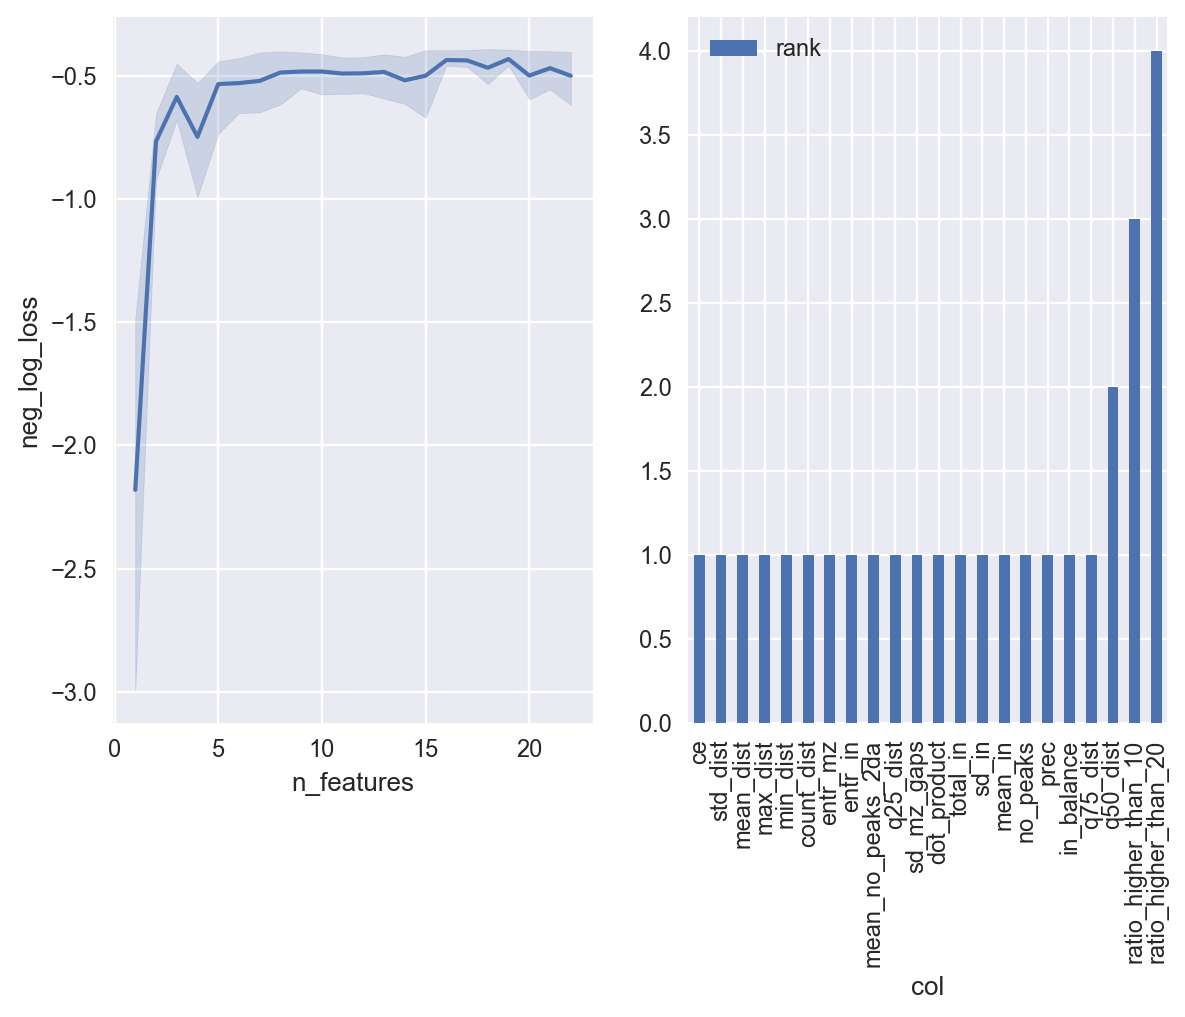

In [19]:
from sklearn.feature_selection import RFECV

score = 'neg_log_loss'

# score = "precision"

estimator = RandomForestClassifier(class_weight="balanced",random_state=seed)
rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=StratifiedKFold(5),
    scoring=score,
    min_features_to_select=1,verbose=1,n_jobs=-1,
)
rfecv.fit(X_df, y)

fig, axes = plt.subplots(1,2)
res = pd.DataFrame(rfecv.grid_scores_)
res["n_features"] = range(1, len(res)+1)
res = res.melt(id_vars="n_features").rename(columns={"value":score,"variable":"fold"})
sns.lineplot(data=res, x="n_features",y=score,ci=99, ax=axes[0])

res2 = pd.DataFrame({"col":colnames, "rank" :rfecv.ranking_, "support" : rfecv.support_})
res2.sort_values(by="rank").plot(x="col", y="rank",kind="bar",ax=axes[1])

# 2D Grid Parameter Search

## Grid Features

In [ ]:
# search for the best 2d histogram
RANGE = range(1,21)

res = {}
for bin1 in RANGE:
    for bin2 in RANGE:
        df = extract_grid_features(data, (bin1, bin2))
        model = RandomForestClassifier(random_state=seed, class_weight='balanced', n_jobs=-1)
        results = validate(df, model)
        res[(bin1,bin2)] = results.describe()[['accuracy', 'precision', "recall", "avg_precision", "roc_auc", "log_loss"]].loc[['mean', 'std']]

In [23]:
def get_datty(res):
    datty = []
    for x in res:
        a, b = x
        y    = res[x].to_dict("records")
        row = y[0]
        for i in y[1]:
            row[f'std_{i}'] = y[1][i]
        row["M"] = a
        row["I"] = b
        datty.append(row)
    datty = pd.DataFrame(datty)
    return datty

In [24]:
get_datty(res).to_csv('datty0')

In [25]:
def print_heatmaps(datty, scores = ["accuracy", 'avg_precision', "roc_auc", 'log_loss']):
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
    colors = ["Greens", "Blues", "Oranges", "Purples"]
    indices = [0,1,2,3]
    smoothing_factor = 1
    
    for score, color, idx in zip(scores, colors, indices):
        matrix = np.zeros((len(RANGE), len(RANGE)))
        for x in datty[["M", "I", score]].sort_values(by=["M","I"]).reset_index(drop=True).to_dict("records"):
            I, M, S = x.values()
            matrix[M - 1, I - 1] = S
        sns.heatmap(filters.gaussian_filter(matrix, smoothing_factor),cbar=True,ax=axes[idx],cmap=color,
                   yticklabels=RANGE, xticklabels=RANGE).invert_yaxis()
        axes[idx].set_title(score)

In [26]:
datty = pd.read_csv('datty0', index_col=0)
datty = datty.rename(columns={'NLLL': 'log_loss'})

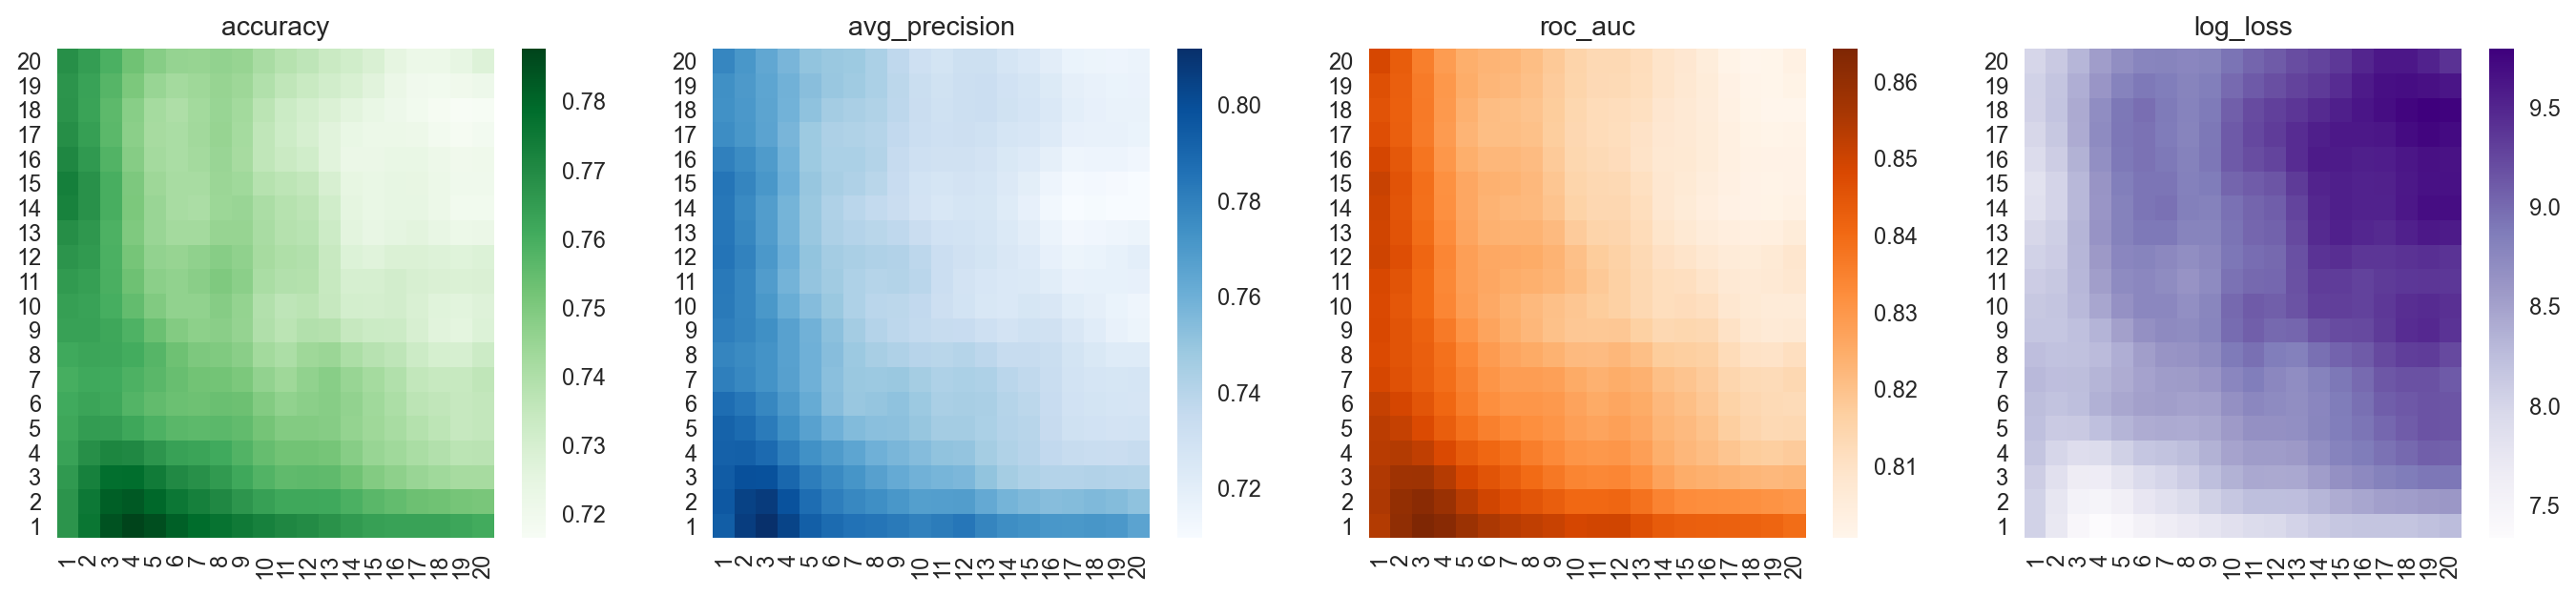

In [27]:
print_heatmaps(datty)

In [28]:
datty["-log_loss"] = -datty['log_loss']

In [29]:
np.round(datty, 2).sort_values(by=['-log_loss', 'avg_precision', "roc_auc", "accuracy"], ascending=False)[:5]

,accuracy,precision,recall,avg_precision,roc_auc,log_loss,std_accuracy,std_precision,std_recall,std_avg_precision,std_roc_auc,std_log_loss,M,I,-log_loss
60,0.80,0.76,0.81,0.82,0.87,6.77,0.04,0.05,0.07,0.04,0.03,1.32,4,1,-6.77
100,0.79,0.75,0.81,0.81,0.87,7.21,0.04,0.06,0.05,0.06,0.03,1.49,6,1,-7.21
42,0.79,0.75,0.78,0.81,0.87,7.24,0.04,0.04,0.07,0.05,0.03,1.38,3,3,-7.24
62,0.79,0.74,0.81,0.79,0.86,7.28,0.04,0.04,0.07,0.04,0.03,1.26,4,3,-7.28
140,0.79,0.74,0.81,0.79,0.86,7.28,0.03,0.04,0.05,0.03,0.02,1.05,8,1,-7.28


In [30]:
np.round(datty[(datty.M ==1) & ((datty.I>=1) & (datty.I<=18))].mean(),2)

accuracy             0.76
precision            0.72
recall               0.77
avg_precision        0.79
roc_auc              0.85
log_loss             8.13
std_accuracy         0.04
std_precision        0.05
std_recall           0.07
std_avg_precision    0.04
std_roc_auc          0.03
std_log_loss         1.39
M                    1.00
I                    9.50
-log_loss           -8.13
dtype: float64

In [32]:
datty['accuracy_score'] = datty['accuracy'] - datty['std_accuracy']
datty['precision_score'] = datty['precision'] - datty['std_precision']
datty['recall_score'] = datty['recall'] - datty['std_recall']
datty['roc_auc_score'] = datty['roc_auc'] - datty['std_roc_auc']
datty['avg_precision_score'] = datty['avg_precision'] - datty['std_avg_precision']
datty['log_loss_score'] = datty['log_loss'] + datty['std_log_loss']
datty["-log_loss_score"] = -datty['log_loss_score']

In [33]:
datty.sort_values(by=['-log_loss_score',"avg_precision_score","roc_auc_score",'accuracy_score'], ascending=False)[:20]

,accuracy,precision,recall,avg_precision,roc_auc,log_loss,std_accuracy,std_precision,std_recall,std_avg_precision,...,M,I,-log_loss,accuracy_score,precision_score,recall_score,roc_auc_score,avg_precision_score,log_loss_score,-log_loss_score
60,0.804020,0.764089,0.814673,0.817666,0.874227,6.768995,0.038091,0.053295,0.067289,0.039035,...,4,1,-6.768995,0.765929,0.710794,0.747384,0.848025,0.778631,8.084627,-8.084627
140,0.789272,0.740803,0.809856,0.791467,0.861765,7.278384,0.030441,0.035170,0.054164,0.033503,...,8,1,-7.278384,0.758831,0.705633,0.755692,0.838588,0.757963,8.329788,-8.329788
180,0.785073,0.741701,0.793411,0.779013,0.854830,7.423421,0.028332,0.032088,0.059149,0.038386,...,10,1,-7.423421,0.756741,0.709614,0.734262,0.830506,0.740627,8.401984,-8.401984
40,0.786125,0.743980,0.793189,0.819023,0.865354,7.387064,0.030777,0.041258,0.049481,0.041911,...,3,1,-7.387064,0.755349,0.702721,0.743708,0.837705,0.777112,8.450063,-8.450063
80,0.787200,0.744811,0.795570,0.781800,0.855268,7.349934,0.032151,0.042339,0.061035,0.035615,...,5,1,-7.349934,0.755049,0.702472,0.734535,0.830265,0.746185,8.460419,-8.460419
62,0.789261,0.739471,0.812237,0.794502,0.858594,7.278772,0.036402,0.040770,0.068017,0.040297,...,4,3,-7.278772,0.752859,0.698701,0.744220,0.832389,0.754205,8.536068,-8.536068
63,0.774535,0.731823,0.783721,0.774732,0.848227,7.787379,0.023572,0.040403,0.066215,0.042095,...,4,4,-7.787379,0.750964,0.691420,0.717506,0.820200,0.732637,8.601532,-8.601532
42,0.790325,0.753574,0.783610,0.809080,0.868315,7.242018,0.040038,0.042093,0.066338,0.047340,...,3,3,-7.242018,0.750287,0.711481,0.717272,0.840539,0.761740,8.624884,-8.624884
220,0.781892,0.735333,0.795570,0.819978,0.867997,7.533268,0.031666,0.032923,0.061035,0.022200,...,12,1,-7.533268,0.750226,0.702410,0.734535,0.847107,0.797778,8.626998,-8.626998
280,0.769250,0.721916,0.783666,0.789418,0.852551,7.969940,0.020499,0.027640,0.061364,0.023228,...,15,1,-7.969940,0.748750,0.694276,0.722301,0.832126,0.766190,8.677963,-8.677963


In [34]:
res2 = pd.DataFrame()
RANGE = range(2,21)

for bin2 in RANGE:
    df = extract_uneven_grid_features(data, bin2)
    model = RandomForestClassifier(random_state=seed, class_weight='balanced', n_jobs=-1)
    results = validate(df, model)
    results["n_bins"] = bin2
    res2 = pd.concat([res2, results])

10it [00:03,  3.08it/s]
10it [00:02,  3.90it/s]
10it [00:03,  2.83it/s]
10it [00:04,  2.18it/s]
10it [00:04,  2.00it/s]
10it [00:04,  2.27it/s]
10it [00:04,  2.29it/s]
10it [00:05,  1.71it/s]
10it [00:05,  1.77it/s]
10it [00:03,  2.93it/s]
10it [00:04,  2.04it/s]
10it [00:04,  2.16it/s]
10it [00:03,  2.58it/s]
10it [00:03,  2.63it/s]
10it [00:04,  2.19it/s]
10it [00:03,  2.69it/s]
10it [00:03,  2.60it/s]
10it [00:04,  2.47it/s]
10it [00:04,  2.31it/s]


<AxesSubplot:xlabel='n_bins', ylabel='value'>

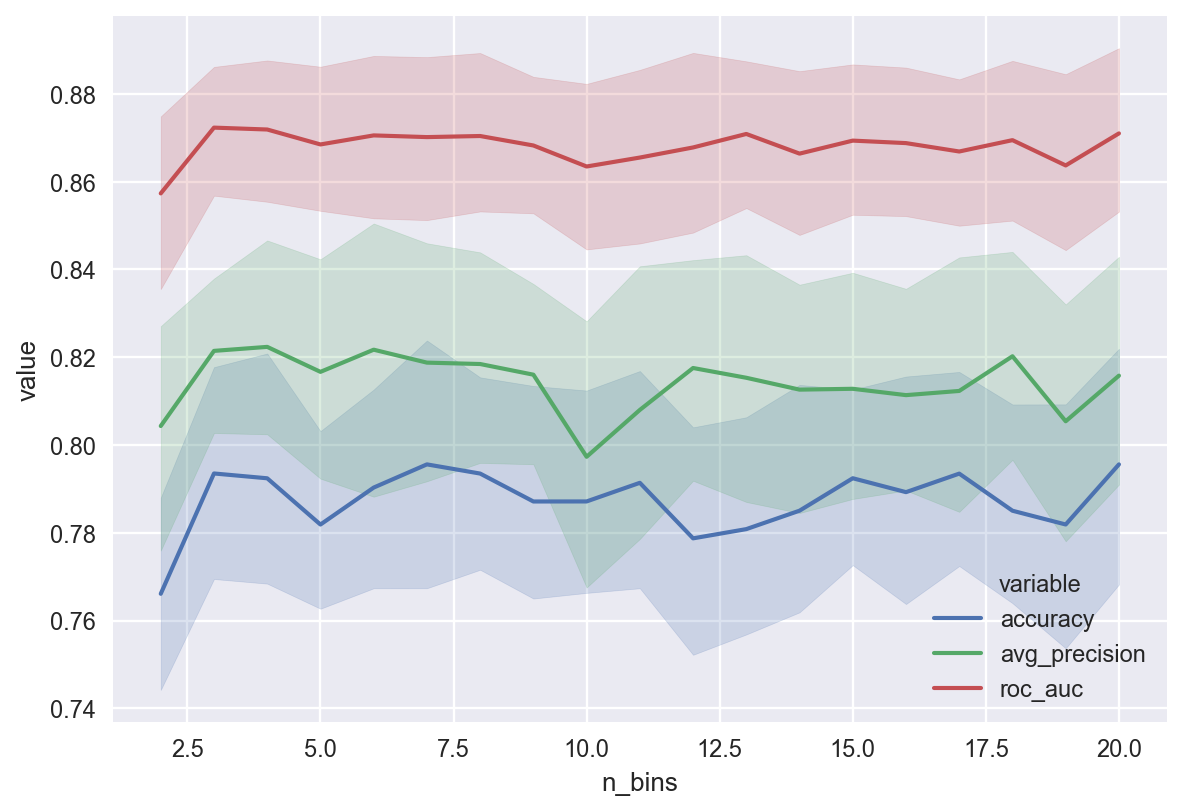

In [37]:
sns.lineplot(data=res2.sort_values(by="log_loss").drop(columns=["log_loss", "recall","precision"]).melt(id_vars="n_bins"),
            x="n_bins", y="value", hue="variable")

In [44]:
datty = []
for x in res:
    b = x
    y    = res[x].to_dict("records")
    row = y[0]
    for i in y[1]:
        row[f'std_{i}'] = y[1][i]
    row["I"] = b
    datty.append(row)
datty = pd.DataFrame(datty)

In [45]:
datty = datty.rename(columns={'NLLL': 'log_loss'})
datty['-log_loss'] = -datty['log_loss']

In [46]:
datty['accuracy_score'] = datty['accuracy'] - datty['std_accuracy']
datty['precision_score'] = datty['precision'] - datty['std_precision']
datty['recall_score'] = datty['recall'] - datty['std_recall']
datty['roc_auc_score'] = datty['roc_auc'] - datty['std_roc_auc']

In [47]:
np.round(datty, 2).sort_values(by=['-log_loss', 'avg_precision', "roc_auc", "accuracy"], ascending=False)[:5]

,accuracy,precision,recall,avg_precision,roc_auc,log_loss,std_accuracy,std_precision,std_recall,std_avg_precision,std_roc_auc,std_log_loss,I,-log_loss,accuracy_score,precision_score,recall_score,roc_auc_score
60,0.80,0.76,0.81,0.82,0.87,6.77,0.04,0.05,0.07,0.04,0.03,1.32,"(4, 1)",-6.77,0.77,0.71,0.75,0.85
100,0.79,0.75,0.81,0.81,0.87,7.21,0.04,0.06,0.05,0.06,0.03,1.49,"(6, 1)",-7.21,0.75,0.69,0.76,0.84
42,0.79,0.75,0.78,0.81,0.87,7.24,0.04,0.04,0.07,0.05,0.03,1.38,"(3, 3)",-7.24,0.75,0.71,0.72,0.84
62,0.79,0.74,0.81,0.79,0.86,7.28,0.04,0.04,0.07,0.04,0.03,1.26,"(4, 3)",-7.28,0.75,0.70,0.74,0.83
140,0.79,0.74,0.81,0.79,0.86,7.28,0.03,0.04,0.05,0.03,0.02,1.05,"(8, 1)",-7.28,0.76,0.71,0.76,0.84


# Validation: Empiric Comparison

In [48]:
d = {
    "comb" : pd.merge(extract_lit(data, base_feats=True), extract_2dh(data, base_feats=False), on=["UID","quality"]),
    "dist" : extract_2dh(data, base_feats=True), 
    "lit" : extract_lit(data, base_feats=True),
    "grid": extract_grid_features(data,bin_dim=(19,1), base_feats=True),
    'uneven_grid' : extract_uneven_grid_features(data, bin_dim=14, base_feats=True)
}

In [51]:
rr = pd.DataFrame()
for decorr in [True, False]:
    for elim in [True, False]:
        for fset in d:
            if fset in ["grid", 'uneven_grid'] and any([elim, decorr]):
                continue
            if fset in ["lit", 'dist'] and elim:
                continue
            df = d[fset].copy()  
            df_train = df[~df.UID.isin(test_uids)].copy().reset_index(drop=True)
            X_df = df_train[[col for col in df_train if col not in ['quality', 'UID']]].copy()
            y = df_train.quality.copy().to_numpy()
            if fset == 'comb' and elim == True and decorr == False:
                X_df = uncorr(X_df, 0.0)
            # remove 
            X_df2 = uncorr(X_df, 0.3) if decorr else X_df
            # remove
            X_df3 = rfecv(X_df2, y) if elim else X_df2
            res = validate(df_train[list(X_df3.columns)+ ["UID","quality"]], RandomForestClassifier(random_state=seed,
                                                      class_weight='balanced',
                                                      n_jobs=-1))
            
            res['no_feats'] = len(X_df3.columns)
            name = fset 
            name += "_uncorr" if decorr else ""
            name += "_rfe" if elim else ""
            name += "_"+str(int(len(X_df3.columns)))
            res["features"] = name

            
            rr = pd.concat([rr, res])

Fitting estimator with 9 features.
Fitting estimator with 8 features.


10it [00:02,  3.43it/s]
10it [00:03,  2.60it/s]
10it [00:04,  2.25it/s]
10it [00:04,  2.48it/s]


Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.


10it [00:04,  2.22it/s]
10it [00:04,  2.35it/s]
10it [00:03,  2.70it/s]
10it [00:03,  2.76it/s]
10it [00:03,  2.57it/s]
10it [00:02,  3.44it/s]


In [52]:
rr

,accuracy,precision,recall,avg_precision,roc_auc,log_loss,no_feats,features
0,0.852632,0.822222,0.860465,0.912319,0.934481,5.089992,7,comb_uncorr_rfe_7
1,0.800000,0.725490,0.880952,0.860035,0.887017,6.907873,7,comb_uncorr_rfe_7
2,0.800000,0.744681,0.833333,0.827339,0.873091,6.907856,7,comb_uncorr_rfe_7
3,0.768421,0.717391,0.785714,0.813203,0.851752,7.998563,7,comb_uncorr_rfe_7
4,0.821053,0.745098,0.904762,0.770455,0.874214,6.180733,7,comb_uncorr_rfe_7
...,...,...,...,...,...,...,...,...
5,0.757895,0.731707,0.714286,0.825986,0.876235,8.362112,16,uneven_grid_16
6,0.736842,0.666667,0.809524,0.720877,0.818509,9.089295,16,uneven_grid_16
7,0.747368,0.714286,0.714286,0.775665,0.828392,8.725687,16,uneven_grid_16
8,0.789474,0.775000,0.738095,0.845849,0.901617,7.271397,16,uneven_grid_16


In [53]:
rr.groupby("features").mean().sort_values(by="log_loss").index

Index(['lit_14', 'comb_rfe_16', 'comb_22', 'lit_uncorr_8', 'comb_uncorr_9',
       'comb_uncorr_rfe_7', 'dist_10', 'dist_uncorr_5', 'uneven_grid_16',
       'grid_21'],
      dtype='object', name='features')

In [54]:
mdf = pd.melt(rr.drop(columns={"log_loss", 'recall', 'precision', 'no_feats'}), id_vars=['features'], var_name=['metrics'])

<AxesSubplot:xlabel='features', ylabel='value'>

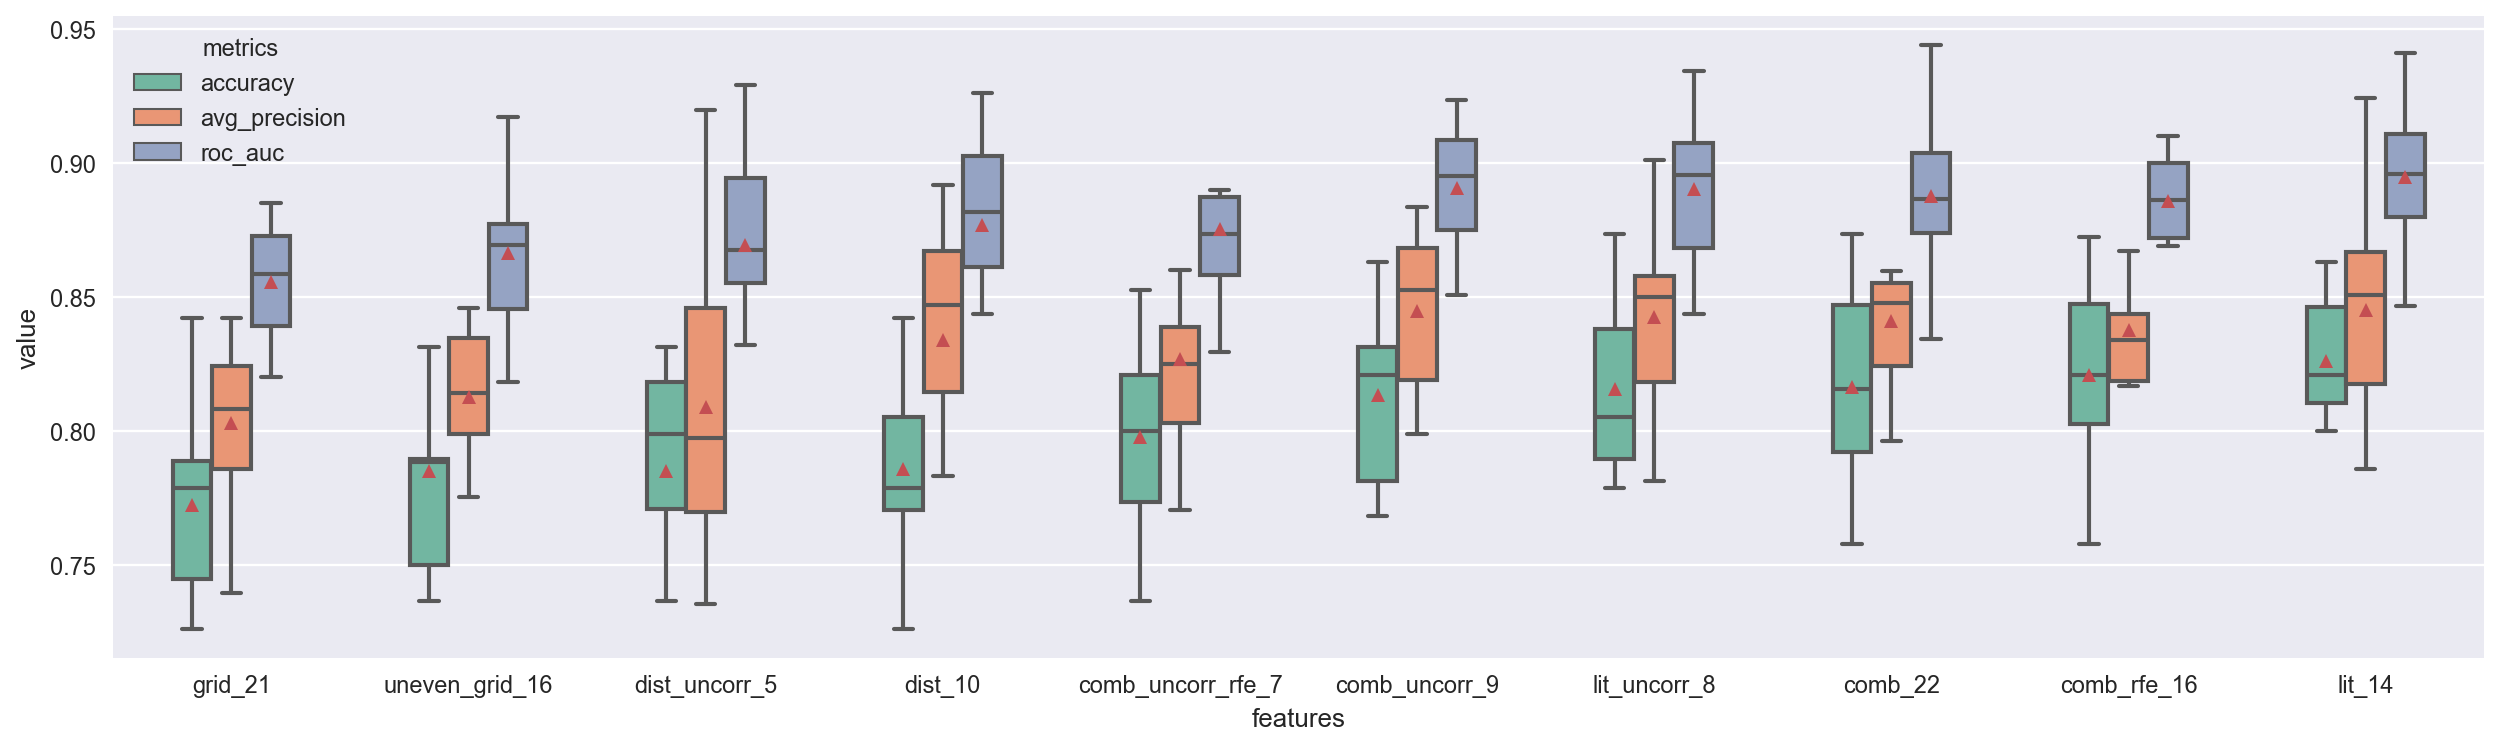

In [55]:
# plt.rcParams["figure.figsize"] = (12,4)
fig, ax = plt.subplots(figsize=(18,5))
sns.boxplot(x="features", y="value",
            hue="metrics", data=mdf,order=rr.groupby("features").mean().sort_values(by="log_loss",ascending=False).index,width=.5,
            palette="Set2", showmeans=True, showfliers=False, ax=ax)

## Test

In [56]:
train = data[~data.UID.isin(test_uids)].copy().reset_index(drop=True)
test  = data[data.UID.isin(test_uids)].copy().reset_index(drop=True)

In [57]:
extract_combined = lambda data : pd.merge(extract_lit(data, base_feats=True), extract_2dh(data, base_feats=False),  on=["UID","quality"])

In [58]:
ddd = [("lit", extract_lit, False, False),
    ("combined_rfe", extract_combined, False, True ),
       ("dist", extract_2dh, False, False),
       ("grid", extract_grid_features, False, False),
       ("uneven_grid", extract_uneven_grid_features, False, False),
       ("baseline", extract_baseline, False, False)
      ]


In [59]:
from sklearn.metrics import roc_curve, precision_recall_curve

In [60]:
results, rocs, prs = [], [], []
for mod in ddd:
    name, feature_extractor, decorr, elim = mod
    
    df_train = feature_extractor(train)
    df_test  = feature_extractor(test)

    X_df_train = df_train[[col for col in df_train if col not in ['quality', 'UID']]].copy()
    X_df_test = df_test[[col for col in df_test if col not in ['quality', 'UID']]].copy()

    y_train = df_train.quality.copy().to_numpy()
    y_test  = df_test.quality.copy().to_numpy()

    if name == 'combined_rfe' and elim == True and decorr == False:
        X_df_train = uncorr(X_df_train, 0.0)
    
    # remove 
    X_df2 = uncorr(X_df_train, 0.3) if decorr else X_df_train
    X_df3 = rfecv(X_df2, y_train) if elim else X_df2

    colnames = X_df3.columns

    clf = RandomForestClassifier(class_weight="balanced", random_state = seed).fit(X_df3, y_train)

    preds, probas = clf.predict(X_df_test[colnames]), clf.predict_proba(X_df_test[colnames])
    probs   = probas[:,1]

    test_res = pd.DataFrame([{"acc" : accuracy_score(y_test, preds),
                            "prec" : precision_score(y_test, preds),
                            "avg_prec" : average_precision_score(y_test, probs),
                             "recall":recall_score(y_test, preds),
                             "roc_auc":roc_auc_score(y_test, probs),
                              'no_feats': int(len(X_df3.columns))
                             }])
    k = pd.DataFrame(precision_recall_curve(y_test, probs)).T.rename(columns={0:"precision",1:"recall", 2:"t"})
    m = pd.DataFrame(roc_curve(y_test, probs)).T.rename(columns={0:"fpr",1:"tpr", 2:"t"})
    m["features"] = name+" ROC = "+str(np.round(roc_auc_score(y_test, probs),2))
    test_res["features"] = name
    k["features"] = name+" AP = "+str(np.round(average_precision_score(y_test, probs),2))

    results += [test_res]
    rocs    += [m]
    prs     += [k]

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.


In [61]:
pd.concat(rocs)

,fpr,tpr,t,features
0,0.000000,0.000000,1.980000,lit ROC = 0.88
1,0.000000,0.014851,0.980000,lit ROC = 0.88
2,0.000000,0.044554,0.970000,lit ROC = 0.88
3,0.000000,0.059406,0.960000,lit ROC = 0.88
4,0.000000,0.079208,0.950000,lit ROC = 0.88
...,...,...,...,...
39,0.407258,0.886139,0.322541,baseline ROC = 0.77
40,0.411290,0.886139,0.312229,baseline ROC = 0.77
41,0.544355,0.970297,0.310501,baseline ROC = 0.77
42,0.802419,0.995050,0.106490,baseline ROC = 0.77


<AxesSubplot:xlabel='recall', ylabel='precision'>

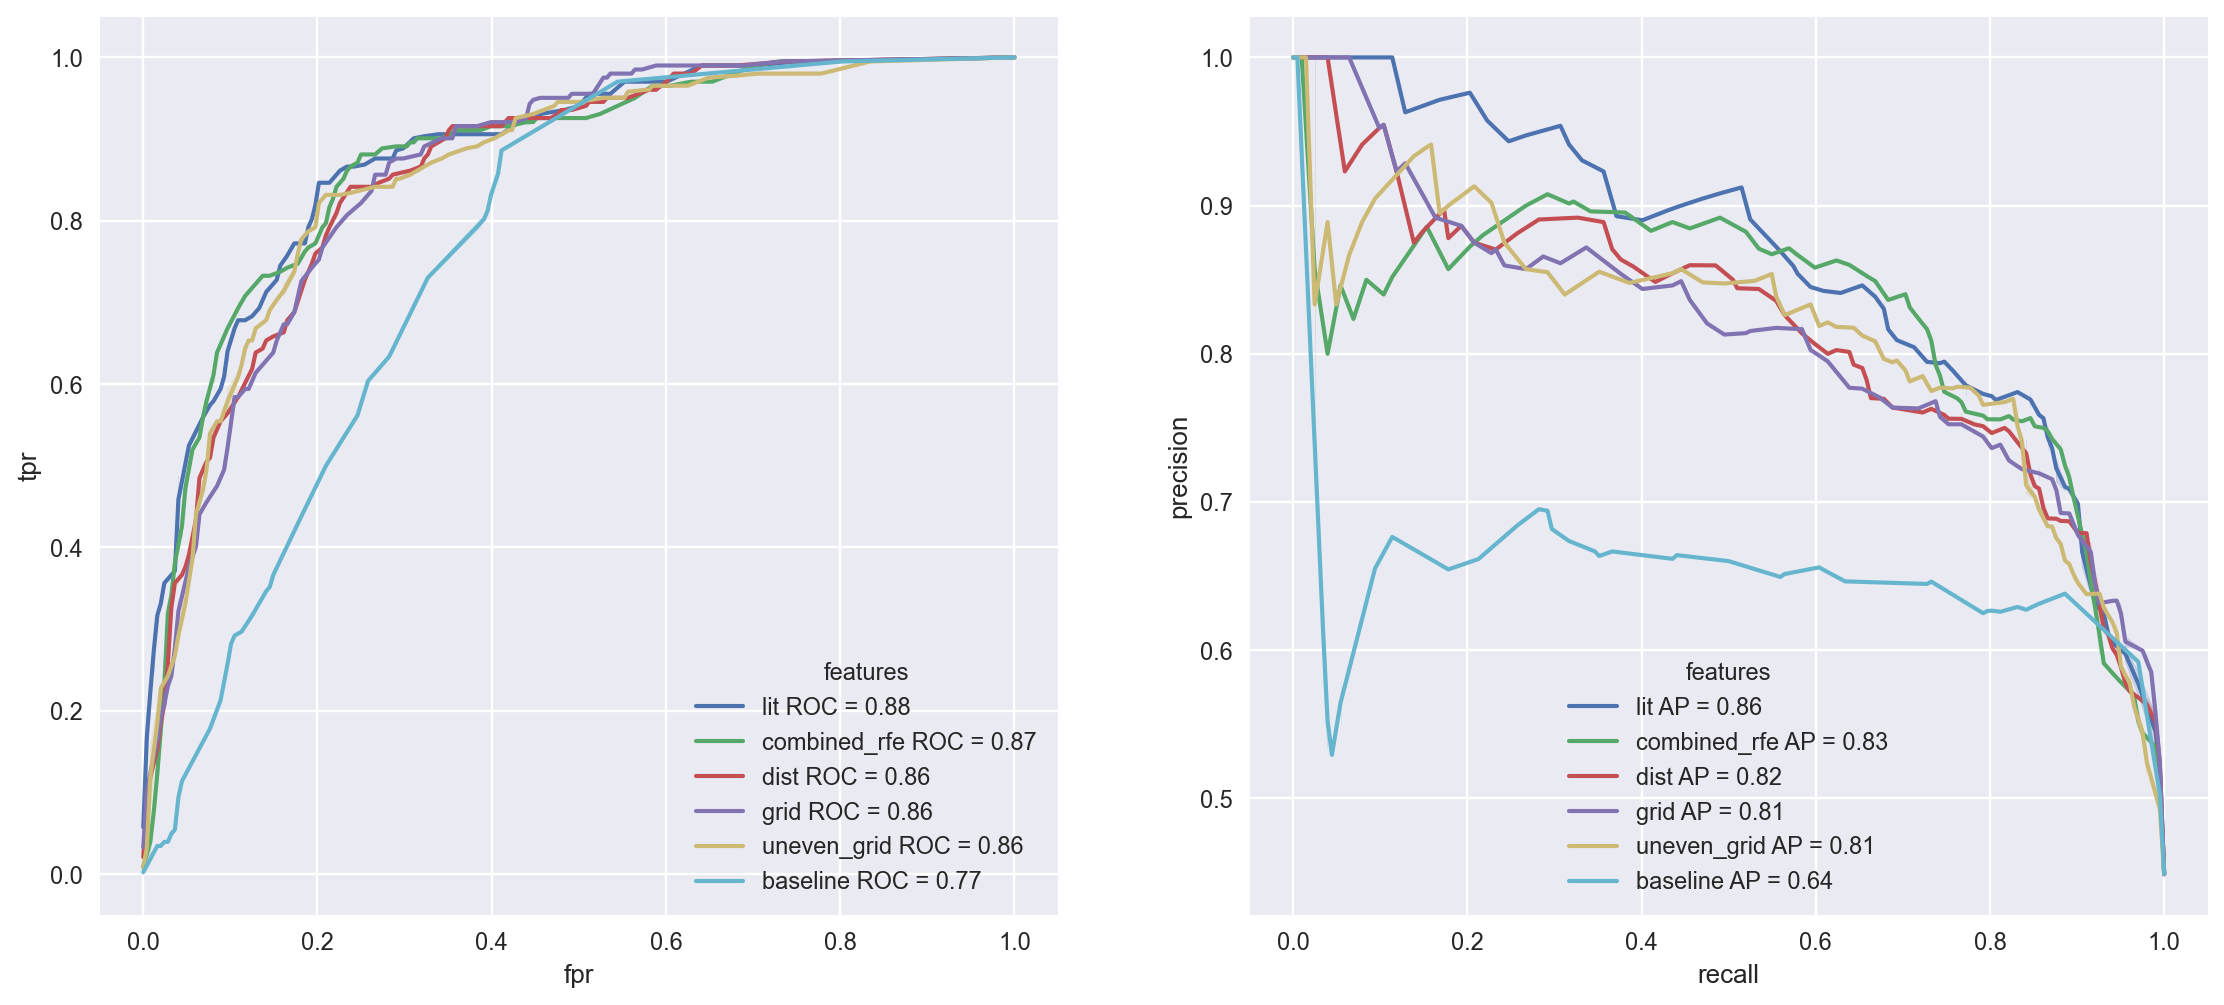

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
sns.lineplot(data=pd.concat(rocs), x="fpr", y="tpr", hue="features", ax=ax1)
sns.lineplot(data=pd.concat(prs), y="precision", x="recall", hue="features", ax=ax2)

In [63]:
pd.concat(results)

,acc,prec,avg_prec,recall,roc_auc,no_feats,features
0,0.804444,0.771429,0.857972,0.801980,0.882406,14,lit
0,0.791111,0.759615,0.825610,0.782178,0.874421,16,combined_rfe
0,0.782222,0.752427,0.815036,0.767327,0.861137,10,dist
0,0.782222,0.728070,0.810791,0.821782,0.861336,21,grid
0,0.788889,0.777202,0.810978,0.742574,0.860099,16,uneven_grid
0,0.697778,0.625954,0.643976,0.811881,0.765480,1,baseline


In [64]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [65]:
df_train = extract_lit(train)
df_test  = extract_lit(test)

X_df_train = df_train[[col for col in df_train if col not in ['quality', 'UID']]].copy()
X_df_test = df_test[[col for col in df_test if col not in ['quality', 'UID']]].copy()

y_train = df_train.quality.copy().to_numpy()
y_test  = df_test.quality.copy().to_numpy()

In [66]:
clf = RandomForestClassifier(random_state=seed, n_jobs=-1, class_weight="balanced")
clf.fit(X_df_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=19)

In [67]:
confusion = confusion_matrix(y_test, (clf.predict_proba(X_df_test)[:,1]>= threshold).astype('int'))
tn, fp, fn, tp = confusion.ravel() 
df=pd.DataFrame(confusion)
df

,0,1
0,99,149
1,6,196


In [68]:
df=df.rename(columns = {0:'Predicted_BAD', 1:'Predicted_GOOD'})
df=df.rename(index = {0: "BAD",
                     1:"GOOD"}  )

In [69]:
df

,Predicted_BAD,Predicted_GOOD
BAD,99,149
GOOD,6,196


<AxesSubplot:>

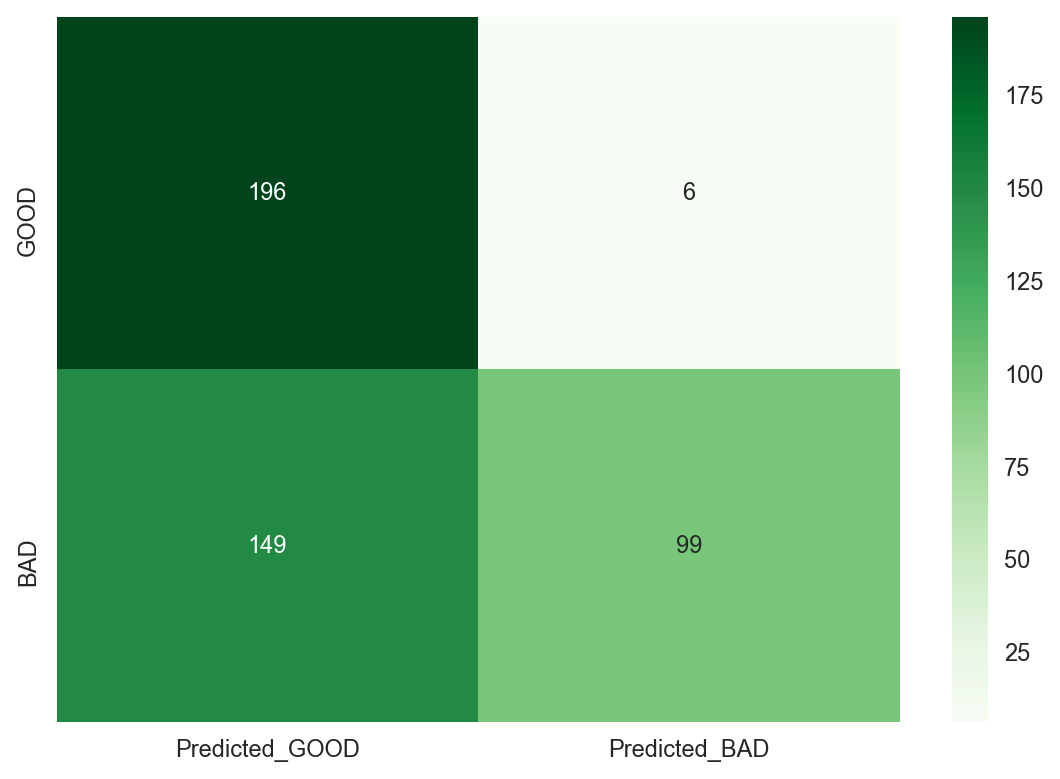

In [70]:
sns.heatmap(df[['Predicted_GOOD','Predicted_BAD']].sort_index(axis=0,ascending=False), cmap='Greens', annot=True,fmt="d")

In [71]:
threshold = 0.661

predicted_proba = clf.predict_proba(X_df_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
print(predicted)

print('acc:', np.round(accuracy_score(y_test, predicted),3))
print('prec:', np.round(precision_score(y_test, predicted),3))
print('recall:', np.round(recall_score(y_test, predicted),3))
# print('roc_auc:', roc_auc_score(y_test, predicted_proba[:,1]))

[1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0
 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1
 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
acc: 0.791
prec: 0.846
recall: 0.653


In [72]:
from sklearn.metrics import fbeta_score

In [ ]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = clf.predict_proba(X_df_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [fbeta_score(y_test, to_labels(probs, t), beta=0.5) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, Fbeta-Score=%.5f' % (thresholds[ix], scores[ix]))